# DM-32147: investigate noise DiaSources

In [1]:
import sys
import glob
import gc
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
#afwDisplay.setDefaultBackend('matplotlib') 
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask
task = ScaleZeroPointTask()

from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord
from astropy import units as u

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame, Image
from lsst.analysis.ap import apdb

In [2]:
repo = '/sdf/group/rubin/repo/main'
butler = dafButler.Butler(repo)

In [5]:
#switch to May 2023 diffim sprint run for now
outputs =  SimpleNamespace(collection = 'u/kherner/DM-32147-diffimg-sprint-20230531',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm32147_diffim_sprint_20230531',
                                      templName='goodSeeing')


In [6]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
               'slot_Shape_flag',
              ]
collection_list = [ outputs.collection ]

In [7]:
#defaultQuery = apdb.ApdbPostgresQuery(outputs.schema, butler=butler,
#                                      instrument="HSC")

# switch to sqlite files for now, 2023-06-11
sqliteFile = '/sdf/group/rubin/user/kherner/DM-32147/convolveTemplate.db'
if not os.path.exists(sqliteFile):
    raise ValueError('file {} does not exist.'.format(sqliteFile))
defaultQuery = apdb.ApdbSqliteQuery(sqliteFile, butler=butler,
                                   instrument='HSC')
defaultQuery.set_excluded_diaSource_flags(badFlagList)
#defaultsources = defaultQuery.load_sources(limit=500000)
defaultobjects = defaultQuery.load_objects()
goodDefault = defaultQuery.load_sources(exclude_flagged=True, limit=1000000)

sqliteFile = '/sdf/group/rubin/user/kherner/DM-32147/autoMode.db'
if not os.path.exists(sqliteFile):
    raise ValueError('file {} does not exist.'.format(sqliteFile))
autoQuery = apdb.ApdbSqliteQuery(sqliteFile, butler=butler,
                                   instrument='HSC')
autoQuery.set_excluded_diaSource_flags(badFlagList)
#defaultsources = defaultQuery.load_sources(limit=500000)
autoobjects = autoQuery.load_objects()
goodAuto = autoQuery.load_sources(exclude_flagged=True, limit=1000000)

sqliteFile = '/sdf/group/rubin/user/kherner/DM-32147/autoMode_noFakes.db'
if not os.path.exists(sqliteFile):
    raise ValueError('file {} does not exist.'.format(sqliteFile))
autoQuery_noFakes = apdb.ApdbSqliteQuery(sqliteFile, butler=butler,
                                   instrument='HSC')
autoQuery_noFakes.set_excluded_diaSource_flags(badFlagList)
#defaultsources = defaultQuery.load_sources(limit=500000)
autoobjects_noFakes = autoQuery_noFakes.load_objects()
goodAuto_noFakes = autoQuery_noFakes.load_sources(exclude_flagged=True, limit=1000000)


/sdf/group/rubin/u/kherner/DM-37986/analysis_ap/python/lsst/analysis/ap/apdb.py:319: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37986/analysis_ap/python/lsst/analysis/ap/apdb.py:319: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._but

In [9]:
gc.collect()

0

In [11]:
flag_map = os.path.join(lsst.utils.getPackageDir("ap_association"),
                                "data/association-flag-map.yaml")
bitmask = defaultQuery._unpacker.makeFlagBitMask(badFlagList, columnName='flags')

In [12]:
visit_det = set(zip(goodDefault['visit'],goodDefault['detector']))

In [14]:
# One visit, one detector for some examples
oneVisit = 11694
oneDetector = 49
selname = 'fakes_goodSeeing'

318.058807	DM-32147-diffimg-sprint-20230531


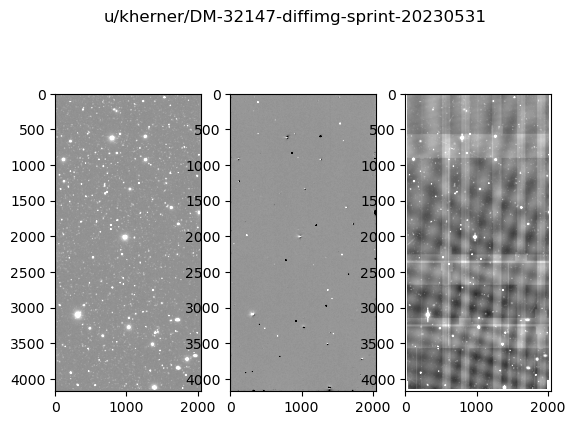

In [15]:
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)
    diffim = butler.get(selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{collections.split("/")[-1]}')

In [16]:
import IPython
from IPython.display import IFrame
afwDisplay.setDefaultBackend('matplotlib') 
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1)

#display2 = afwDisplay.Display(frame=2, name='DM-37622-2')
#display3 = afwDisplay.Display(frame=3, name='DM-37622-3')
#display4 = afwDisplay.Display(frame=4, name='DM-37622-4')

#display1 = afwDisplay.Display('DM-37622')

#IFrame(display1._url, 1000, 1200)
IFrame(display1.getClient().get_firefly_url(), 1000, 1200)


In [17]:
display1.mtv(calexp)

In [18]:
with display1.Buffering():
    for _,record in (goodDefault.loc[(goodDefault['visit']==oneVisit)&\
                                     (goodDefault['detector']==oneDetector)]).iterrows():
        display1.dot('x', record['x'], record['y'], size=30, ctype='cyan')

### Per the ticket, there's some suspicion that sources without an obvious counterpart in the science image seem to show up more when you might have a detection SNR above 5 sigma in psFlux, but the apFlux measurement may be "less secure". Let's look at sources with apFux/apFluxErr < 5 sigma.

In [19]:
apLow = goodDefault.loc[(abs(goodDefault['psFlux'])/goodDefault['psFluxErr'] >=10)&\
                        (abs(goodDefault['apFlux'])/goodDefault['apFluxErr'] <5)]

In [20]:
print('{} sources with apFlux/apFluxerr < 5'.format(len(apLow)))

900 sources with apFlux/apFluxerr < 5


(array([ 25.,  38.,  41.,  66.,  77.,  97., 130., 141., 150., 135.]),
 array([0.01730131, 0.51546779, 1.01363426, 1.51180073, 2.00996721,
        2.50813368, 3.00630016, 3.50446663, 4.00263311, 4.50079958,
        4.99896605]),
 <BarContainer object of 10 artists>)

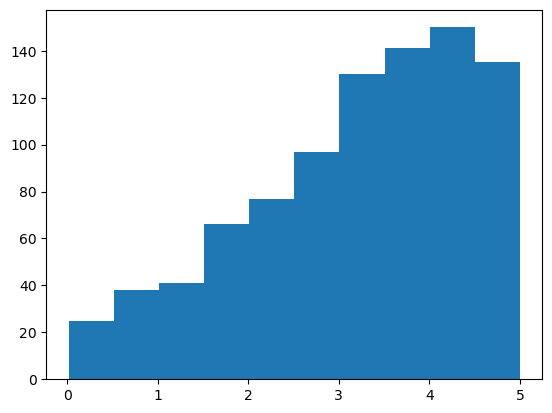

In [21]:
plt.hist(abs(apLow['apFlux'])/apLow['apFluxErr'])

(array([  0.,   0.,   0.,   0.,   0.,  19.,   8.,   6.,   6.,  40., 151.,
        150.,  92.,  88.,  59.,  61.,  52.,  30.,  19.,  17.,  20.,  13.,
          9.,  11.,   8.,   7.,   4.,   2.,   3.,   0.,   3.,   3.,   1.,
          2.,   3.,   0.,   1.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

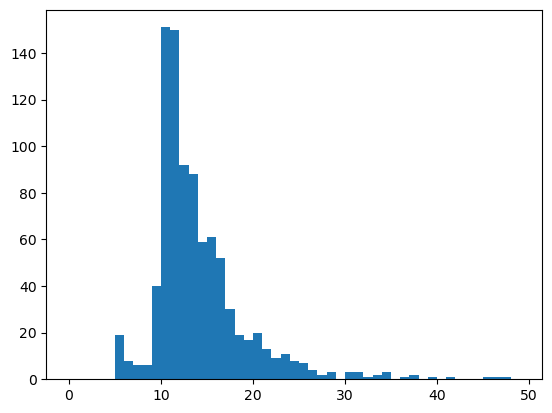

In [22]:
plt.hist(apLow['snr'], bins=range(0,50))

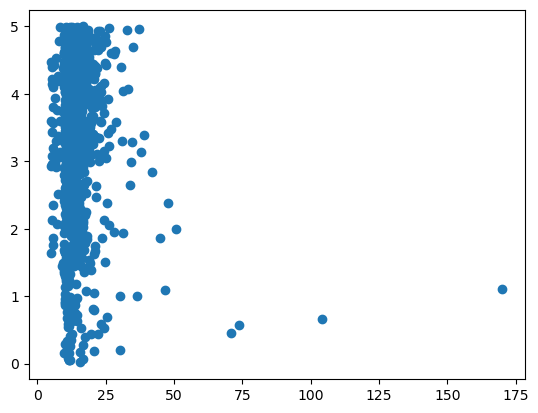

In [23]:
plt.scatter(apLow['snr'],abs(apLow['apFlux'])/apLow['apFluxErr'])

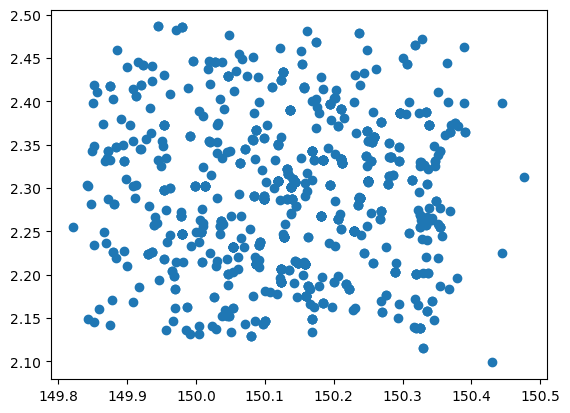

In [25]:
plt.scatter(apLow['ra'], apLow['decl'])
                                

(array([  0.,   0.,   0.,   0.,   0.,  19.,   8.,   6.,   6.,  40., 151.,
        150.,  92.,  88.,  59.,  61.,  52.,  30.,  19.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

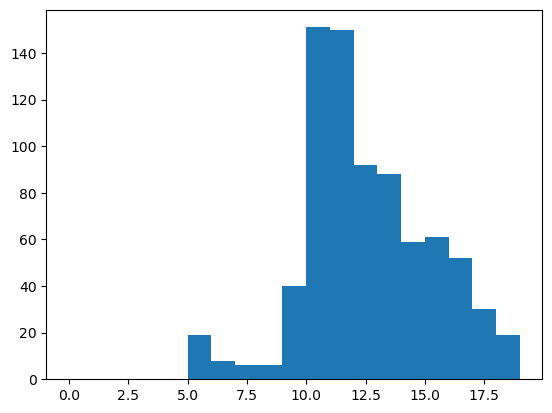

In [26]:
plt.hist(apLow['snr'], bins=range(0,20))

### First we should make the cutouts of all sources. Only need to do this once.

In [27]:
from lsst.analysis.ap import plotImageSubtractionCutouts as pisco
config = pisco.PlotImageSubtractionCutoutsConfig()
config.url_root = ''
config.add_metadata = True
config.diff_image_type = 'fakes_goodSeeingDiff'
outbase = os.path.join(os.environ['HOME'],'u','DM-32147')
cDefault = pisco.PlotImageSubtractionCutoutsTask(output_path=outbase+\
                                                "/cutouts_fakes_goodSeeingDiff_DM-32147_diffim_sprint_convolveTemplate",
                                                    config=config)
cauto = pisco.PlotImageSubtractionCutoutsTask(output_path=outbase+"/cutouts_fakes_goodSeeingDiff_DM-32147_diffim_sprint_autoMode",
                                               config=config)
gsdconfig = pisco.PlotImageSubtractionCutoutsConfig()
gsdconfig.url_root = ''
gsdconfig.add_metadata = True
gsdconfig.diff_image_type = 'goodSeeingDiff'

cDefgSD = pisco.PlotImageSubtractionCutoutsTask(output_path=outbase+\
                                                "/cutouts_goodSeeingDiff_DM-32147_diffim_sprint_convolveTemplate",
                                                    config=config)
cauto_noFakes = pisco.PlotImageSubtractionCutoutsTask(output_path=outbase+\
                                                "/cutouts_goodSeeingDiff_DM-32147_diffim_sprint_autoMode_noFakes",
                                                    config=config)

In [28]:
gc.collect()

55

In [29]:
from IPython.display import Image
def plotSources(data, visit=None, detector=None, path=None, chunk_size=10000, stride=1,
               offset=0, limit=-1):
    if path is None:
        raise ValueError('Image path is required.')
    nplotted = 0
    idx = 0
    if visit is not None and detector is not None:
        firstLoc = data.loc[(data['visit'] == visit) & (data['detector'] == detector)]
    elif detector is not None:
        firstLoc = data.loc[(data['visit'] == visit)]
    elif visit is not None:
        firstLoc = data.loc[(data['detector'] == detector)]
    else:
        firstLoc = data
    if not isinstance(stride, int) or stride < 1:
        raise ValueError('stride must be a positive integer.')
    for _, irow in firstLoc.iterrows():
        if limit > -1 and nplotted >= limit: return
        if idx < offset:
            idx += 1
            continue
        if (idx+offset)%stride == 0:
            print(irow['diaSourceId'])
            chunked = (irow['diaSourceId'] // chunk_size)* chunk_size
            fpath = os.path.join(path, f"images/{chunked}/{irow['diaSourceId']}.png")
            if not os.path.exists(fpath):
                print("ERROR: {}: no such file".format(fpath))
                idx += 1
                continue
            display(Image(filename=fpath))
            nplotted += 1
        idx += 1

In [30]:
plotSources(apLow.loc[apLow['snr']>10], oneVisit, oneDetector, cDefault._output_path, offset=0,
            limit=20)

12601541420646916


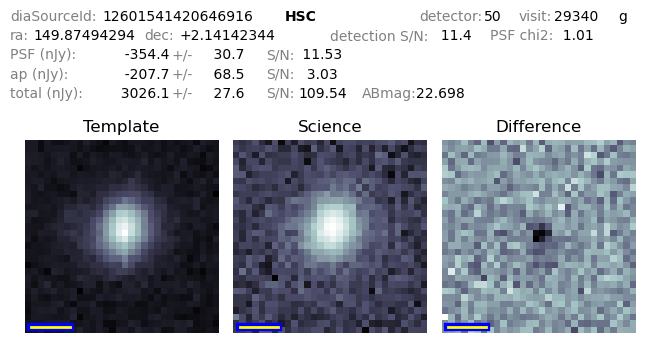

In [31]:
plotSources(apLow.loc[(apLow['snr']>10)&(apLow['isDipole']==False)], 29340, 50, cDefault._output_path, offset=0,
            limit=20)

In [32]:
plotSources(apLow.loc[(apLow['snr']>15)&(apLow['isDipole']==False)], 11702, 49, cDefault._output_path, offset=0,
            limit=20)

In [33]:
dipoleLow = apLow.loc[apLow['isDipole']==True]

In [34]:
apLow_snrHigh_noDipole = apLow.loc[(apLow['snr']>10)&(apLow['isDipole']==False)]

517219289137761


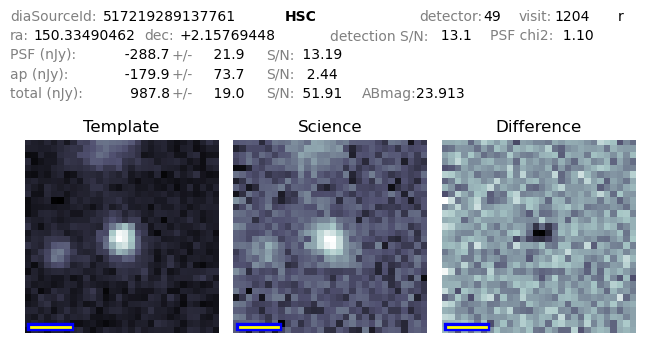

517219289137769


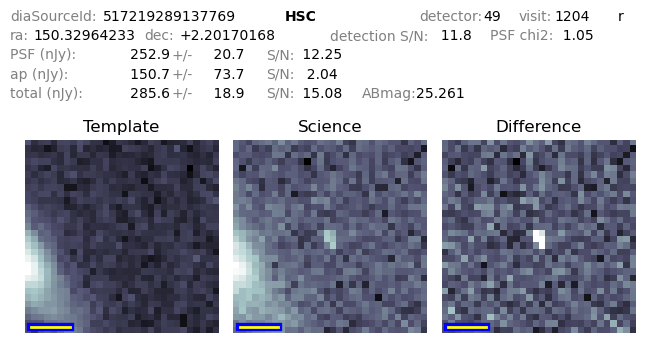

517219289137771


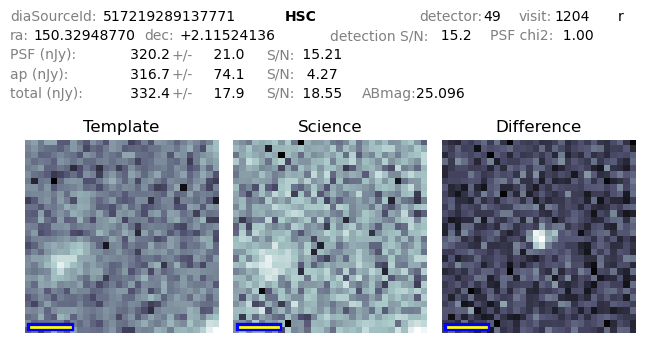

517219289137786


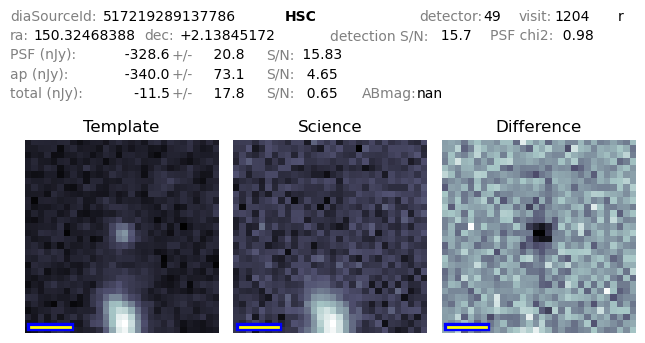

517219289137984


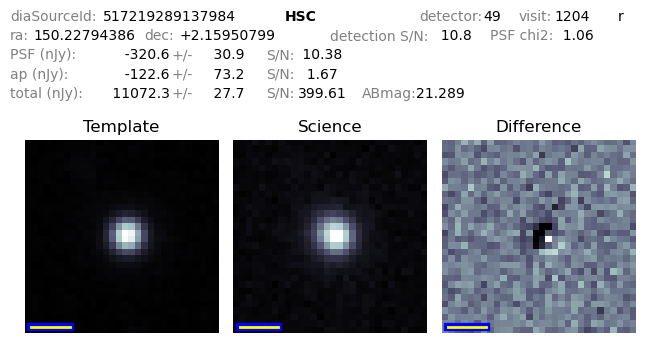

517219289137993


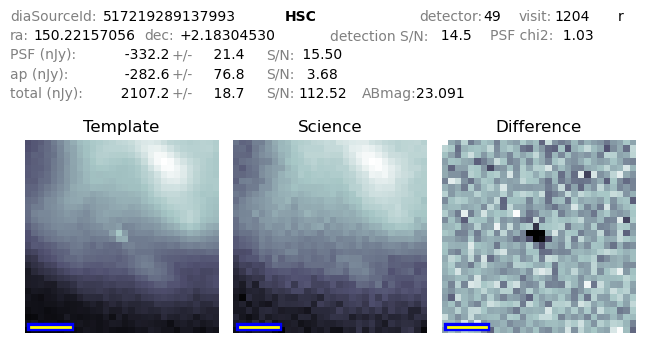

517219289138038


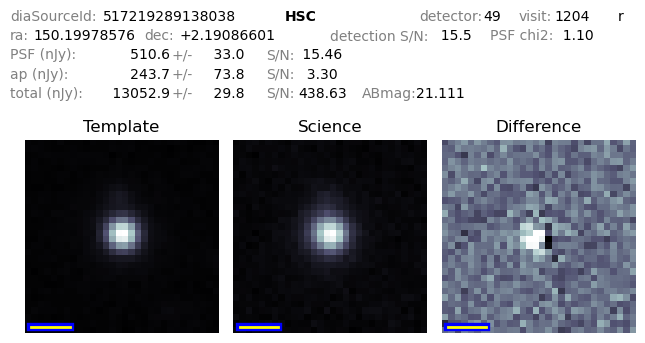

517219289138066


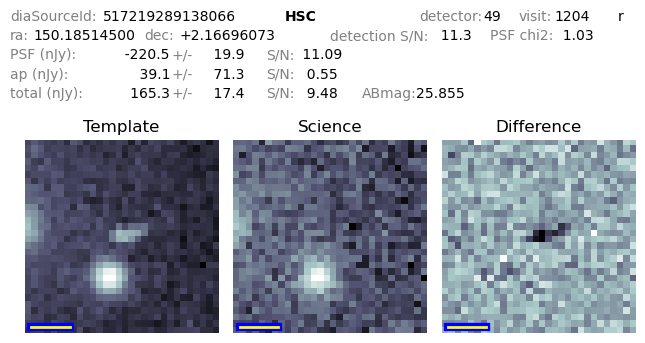

517219289138131


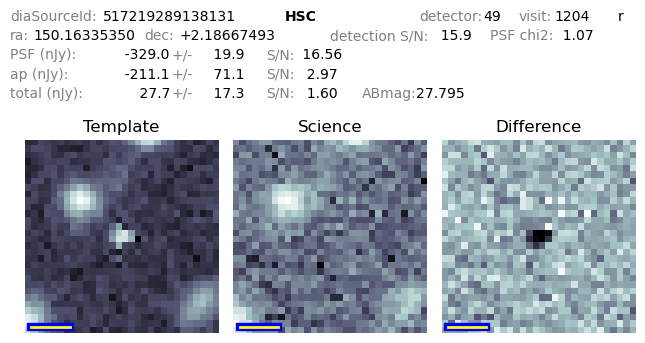

517219289138136


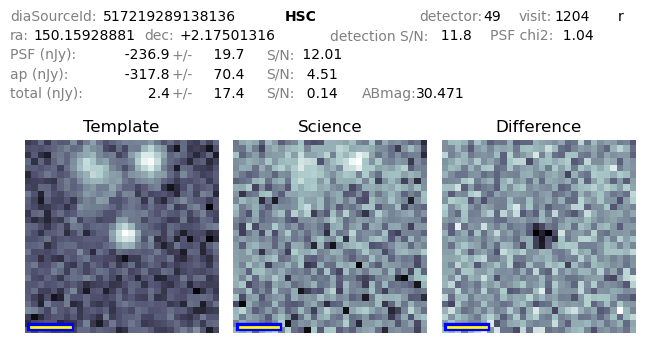

In [35]:
plotSources(apLow_snrHigh_noDipole, path=cDefault._output_path, offset=0,
            limit=10)

517219289137761


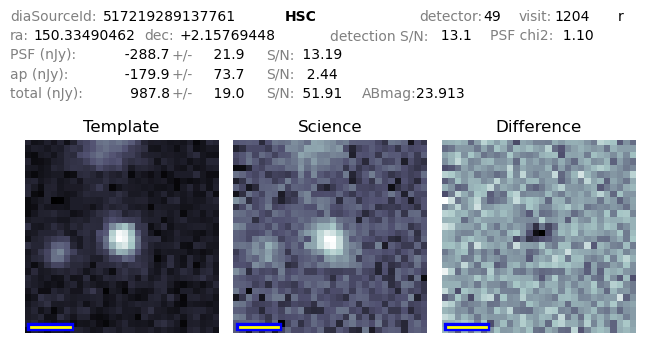

517219289137769


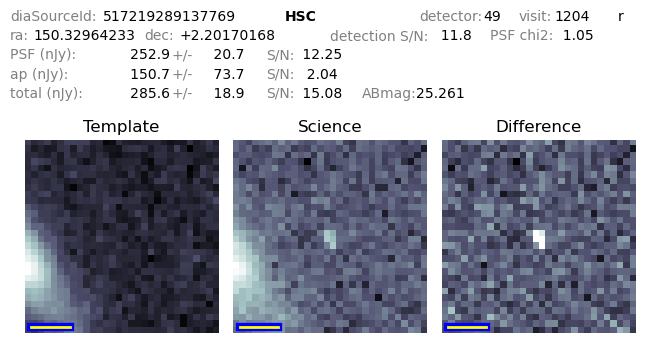

517219289137771


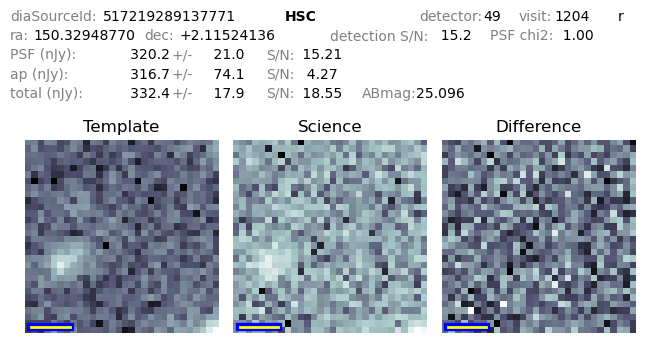

517219289137786


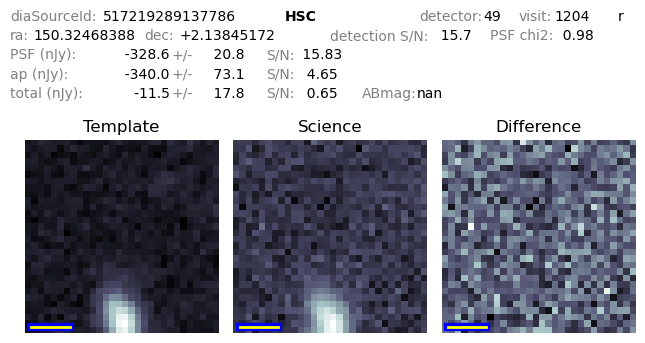

517219289137984


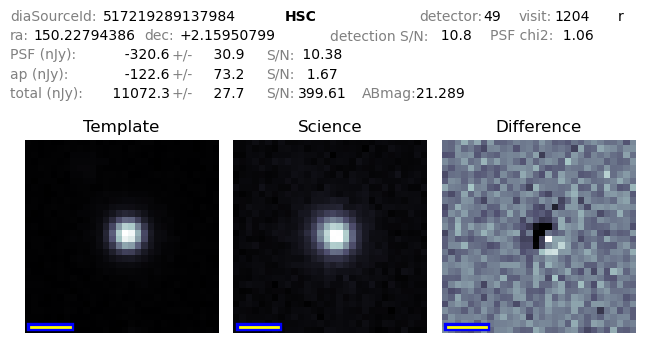

517219289137993


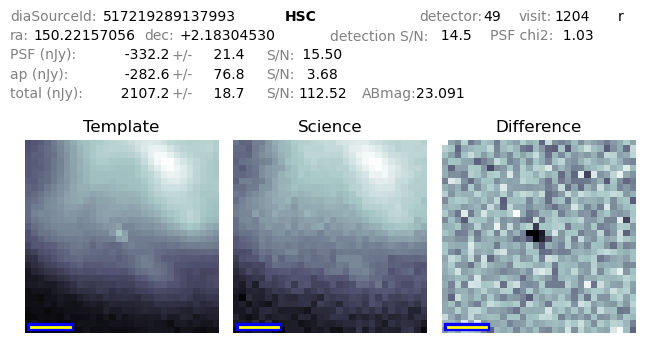

517219289138038


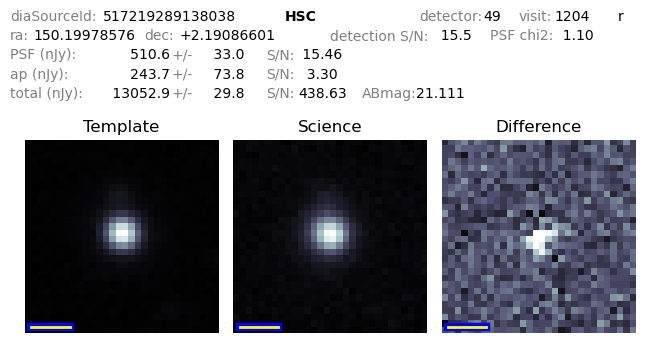

517219289138066


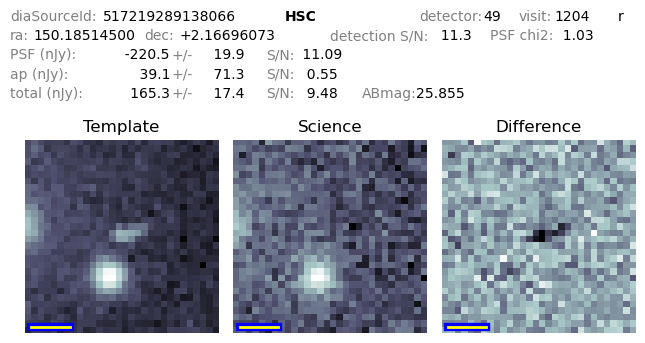

517219289138131


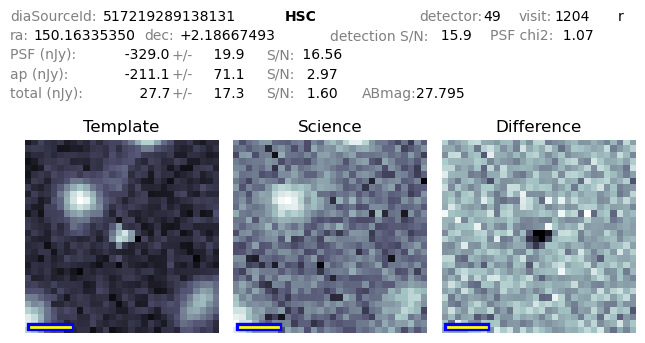

517219289138136


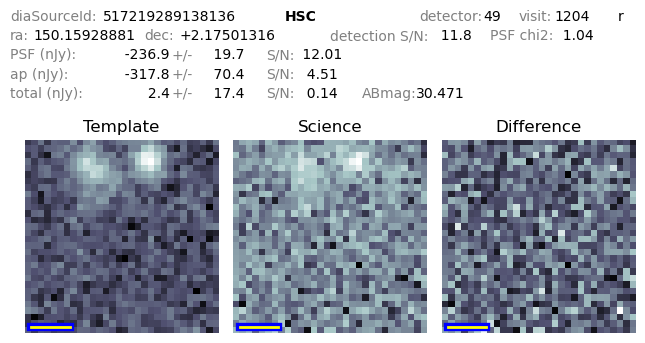

In [36]:
plotSources(apLow_snrHigh_noDipole, path=cDefgSD._output_path, offset=0,
            limit=10)

In [37]:
dipoleAll = goodDefault.loc[goodDefault['isDipole']==True]

In [38]:
dLLen = len(dipoleLow)
aLLen = len(apLow)
defLen = len(goodDefault)
dALen = len(dipoleAll)
print(dLLen/aLLen, (dALen-dLLen)/(defLen-aLLen))

0.10555555555555556 0.15734538090045178


### Look at stuff with the auto mode run

In [39]:
autoLow = goodAuto.loc[(abs(goodAuto['psFlux'])/goodAuto['psFluxErr'] >=10)&\
                        (abs(goodAuto['apFlux'])/goodAuto['apFluxErr'] <5)]
autoLow_noFakes = goodAuto_noFakes.loc[(abs(goodAuto_noFakes['psFlux'])/goodAuto_noFakes['psFluxErr'] >=10)&\
                        (abs(goodAuto_noFakes['apFlux'])/goodAuto_noFakes['apFluxErr'] <5)]

In [40]:
autoLow_snrHigh_noDipole = autoLow.loc[(autoLow['snr']>10)&(autoLow['isDipole']==False)]
print(len(autoLow_snrHigh_noDipole))
autoLow_noFakes_snrHigh_noDipole = autoLow_noFakes.loc[(autoLow_noFakes['snr']>10)&(autoLow_noFakes['isDipole']==False)]
print(len(autoLow_noFakes_snrHigh_noDipole))


723
340


517219289137761


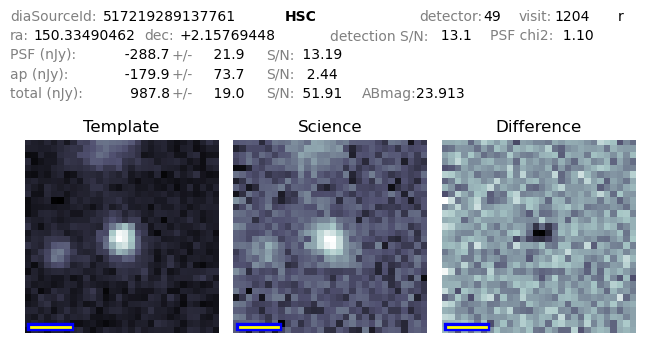

517219289137769


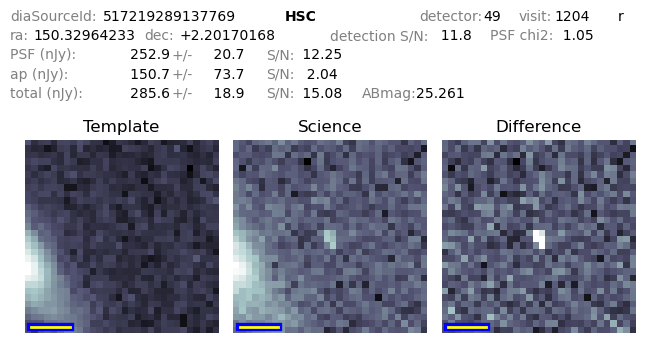

517219289137771


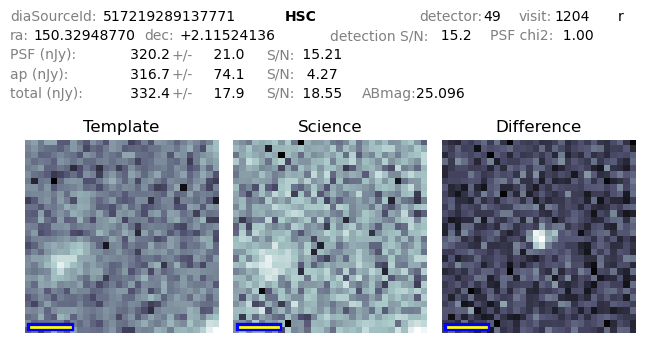

517219289137786


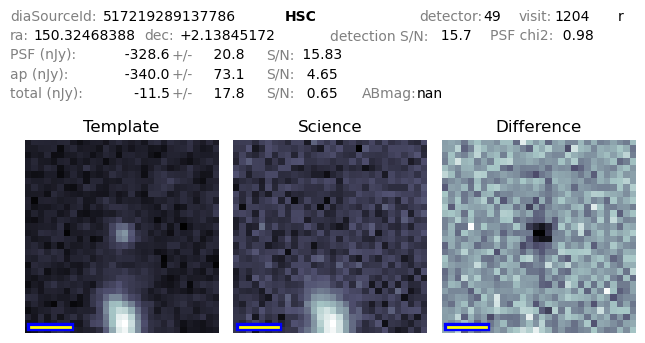

517219289137984


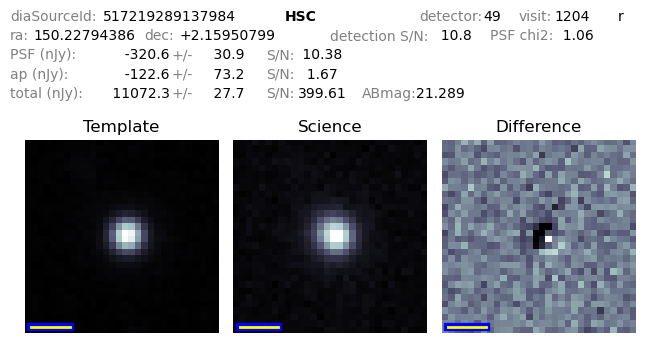

In [41]:
plotSources(autoLow_snrHigh_noDipole, path=cauto._output_path, offset=0,
            limit=5)

517219289137730


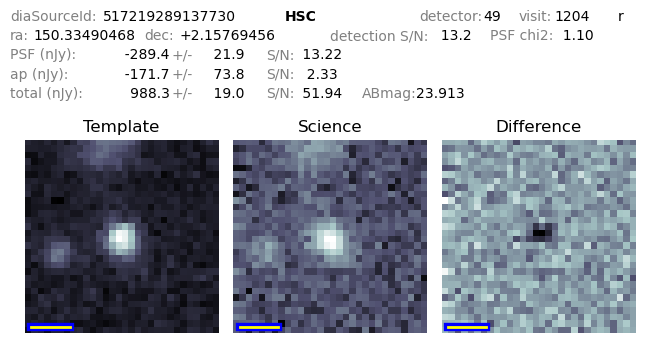

517219289137738


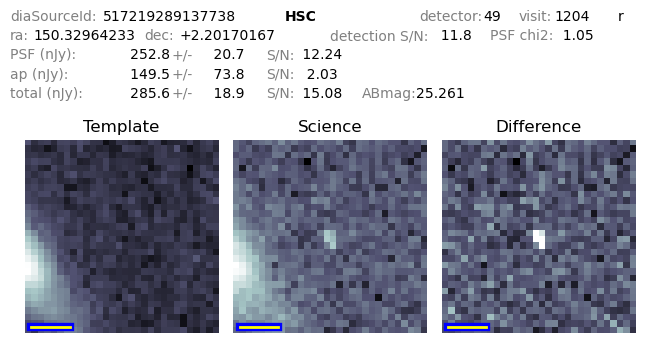

517219289137947


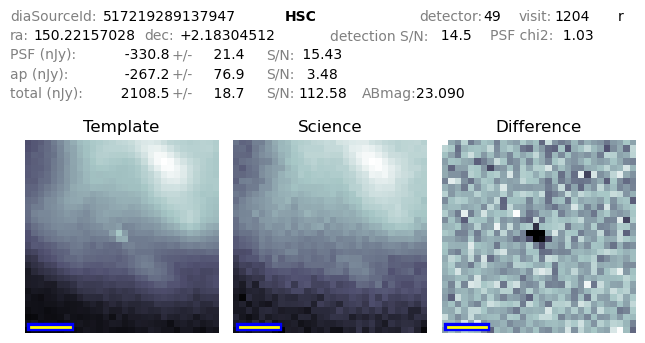

517219289137986


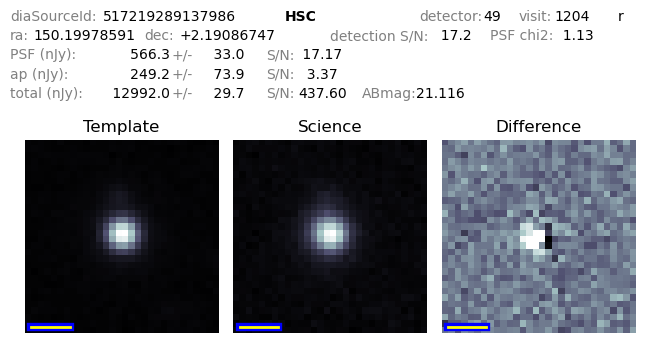

517219289138012


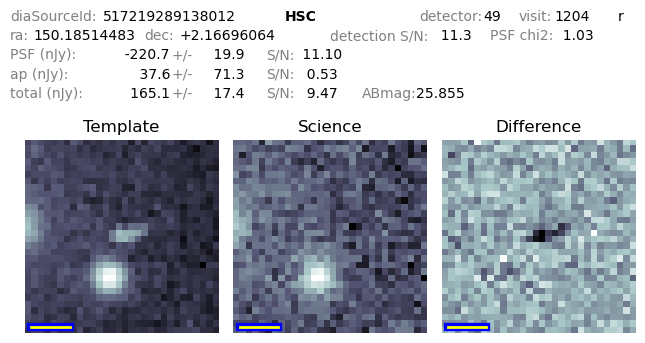

517219289138072


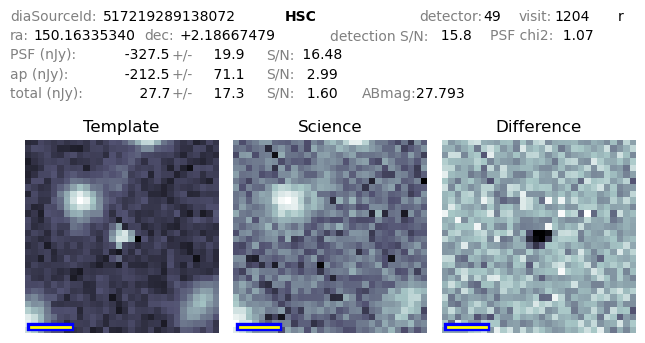

517221436622353


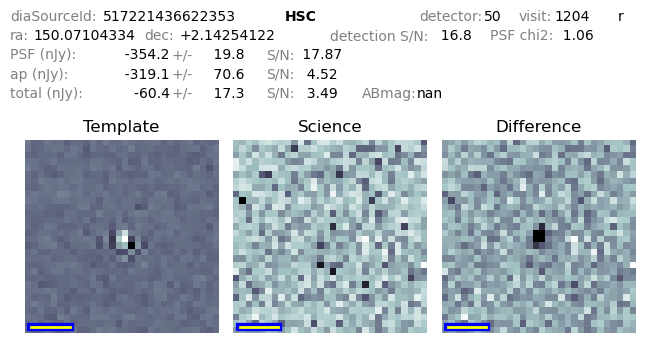

517221436622393


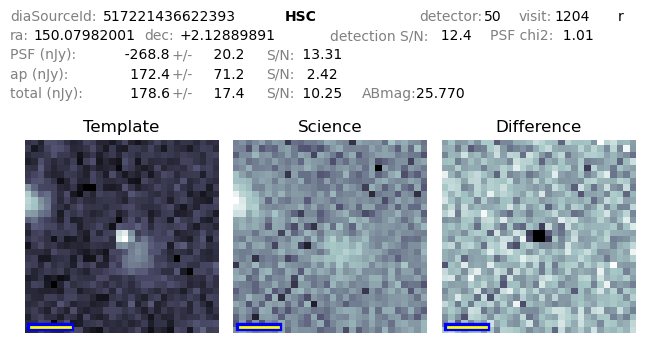

517236469007103


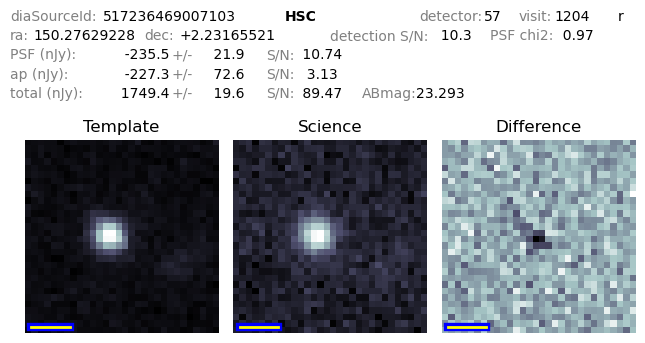

517236469007254


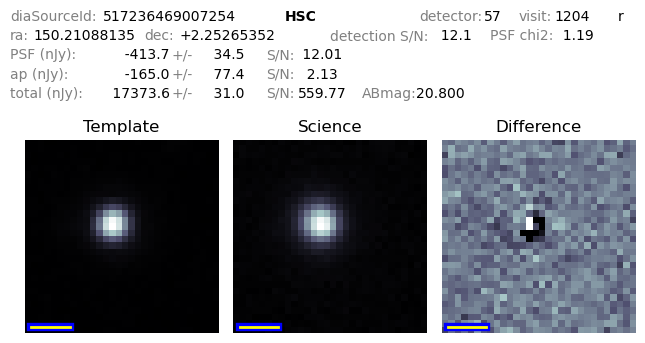

517238616490736


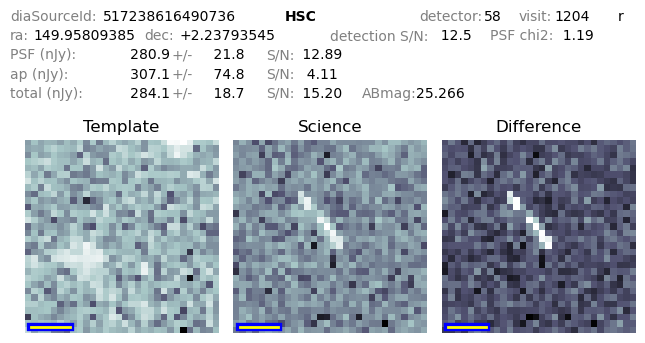

517238616490887


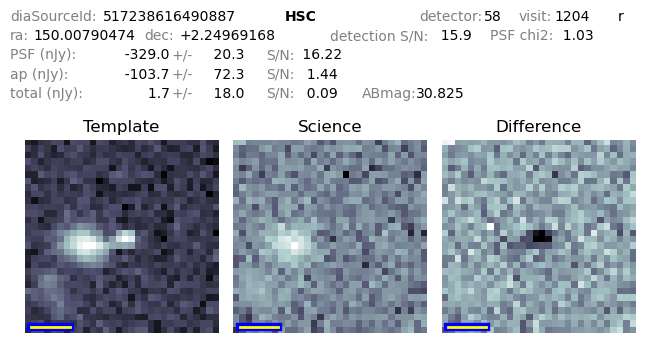

517238616490936


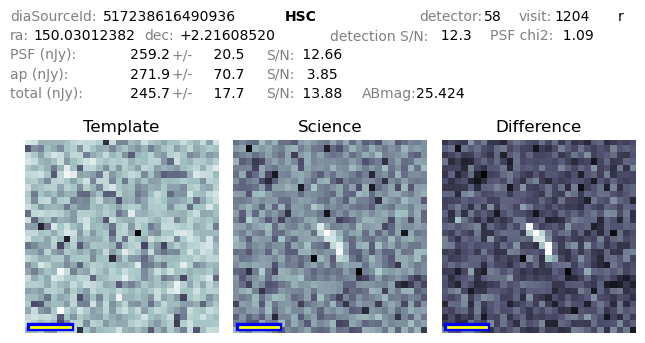

517238616491188


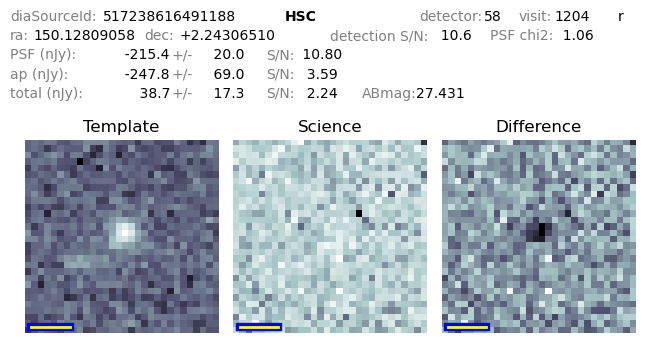

517253648876157


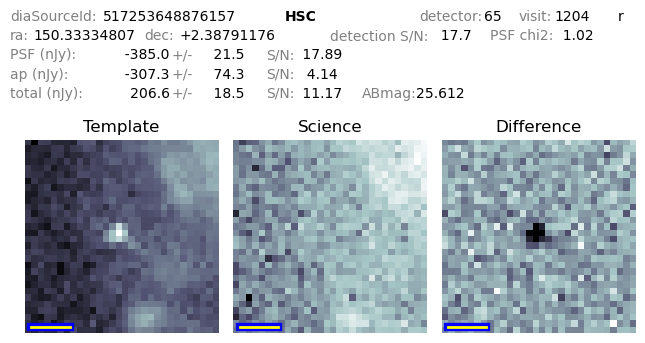

517253648876209


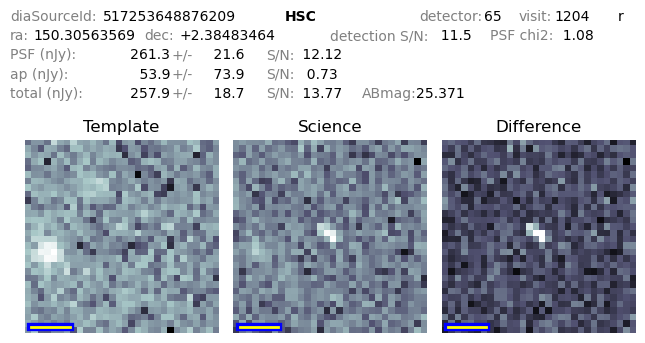

517253648876294


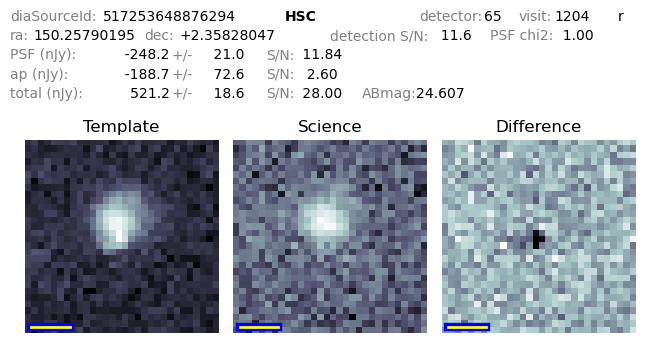

517253648876302


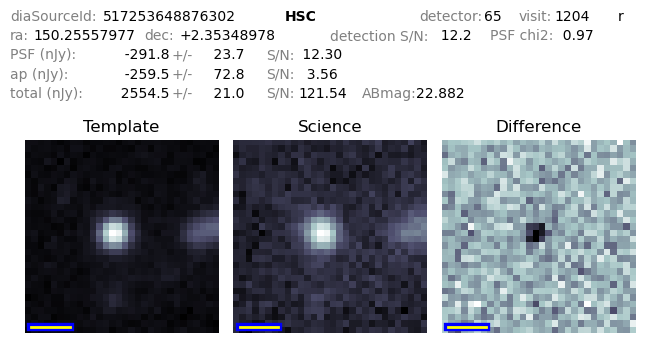

517253648876420


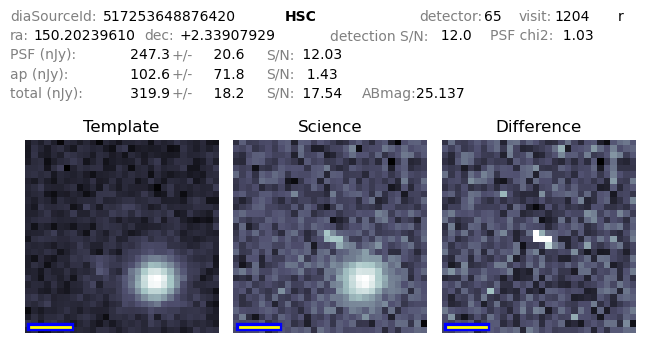

517253648876516


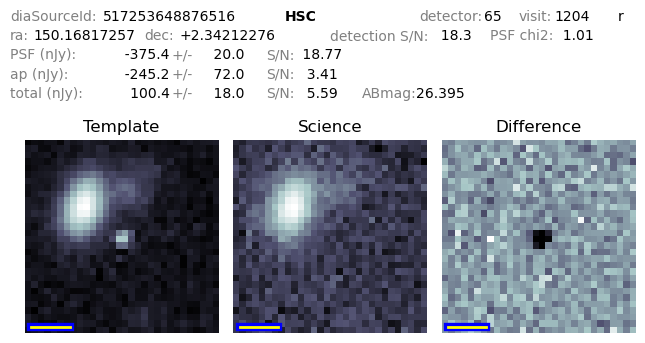

517255796360007


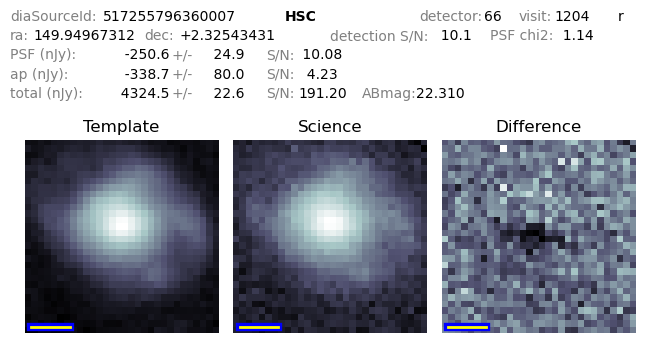

517255796360331


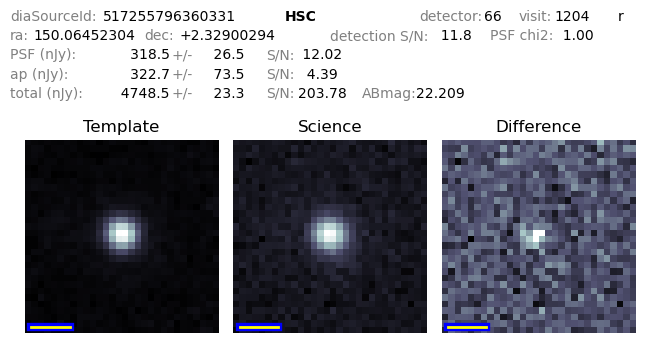

517255796360378


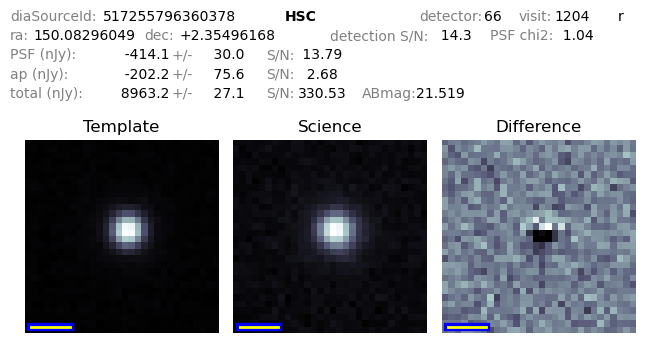

518937276056158


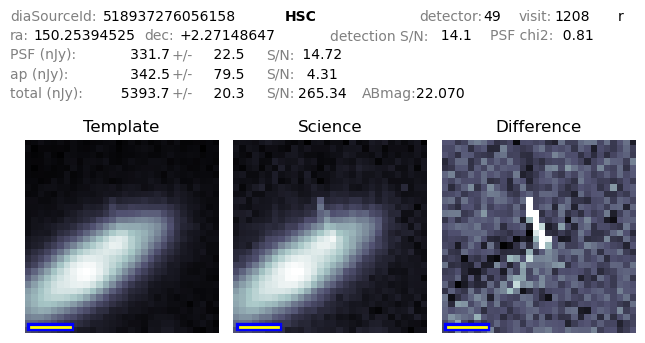

518937276056256


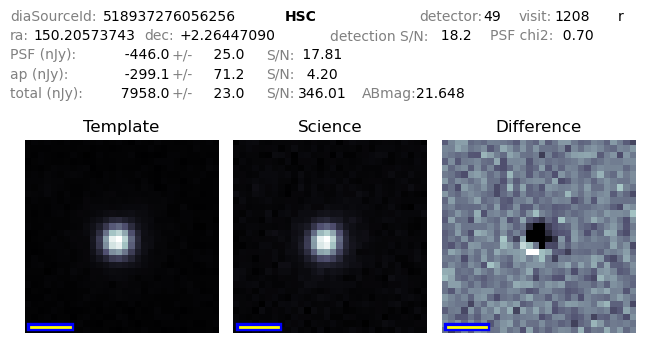

518937276056387


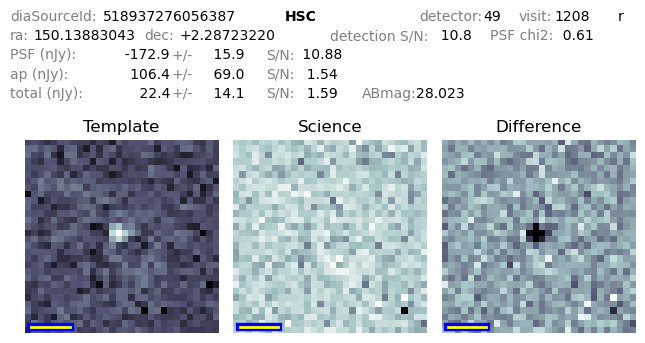

518937276056411


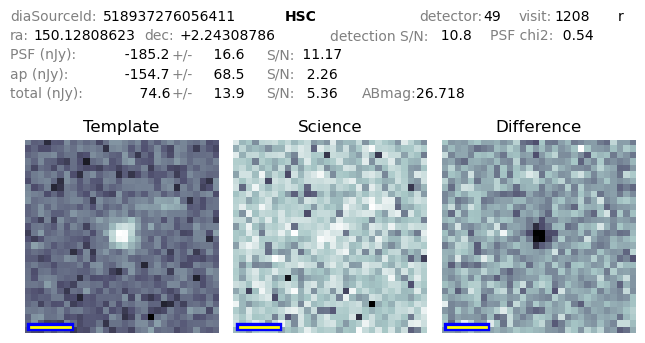

518937276056462


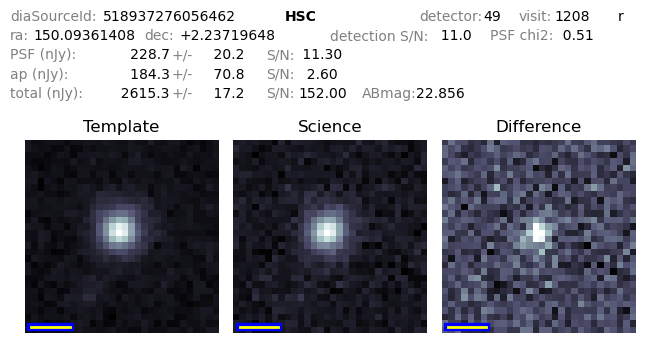

518939423540145


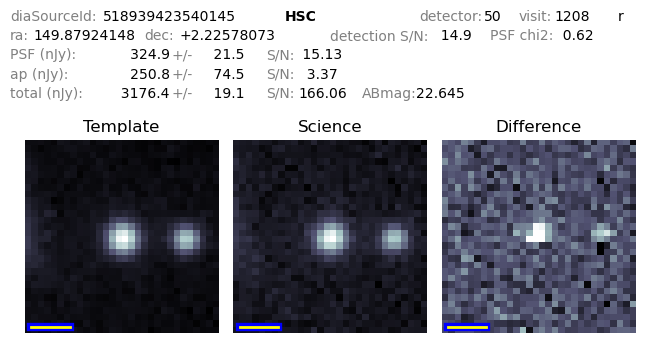

518939423540196


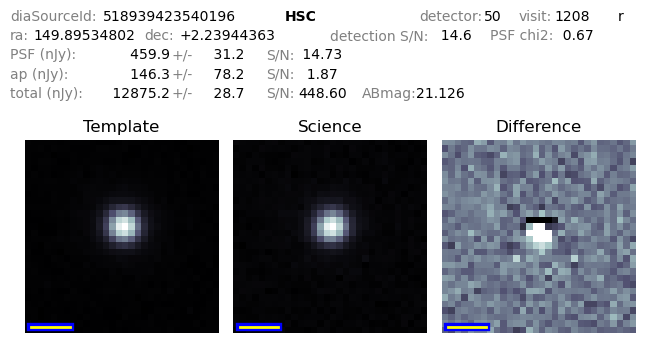

518939423540211


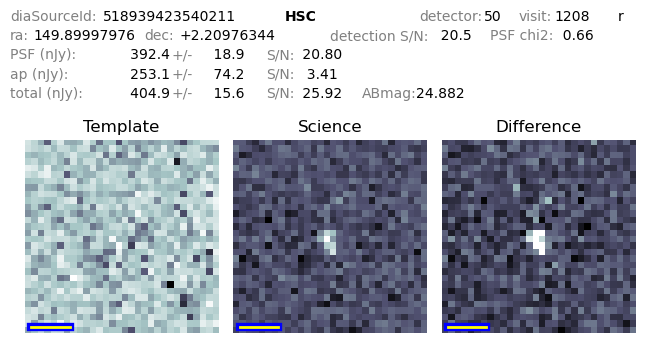

518939423540306


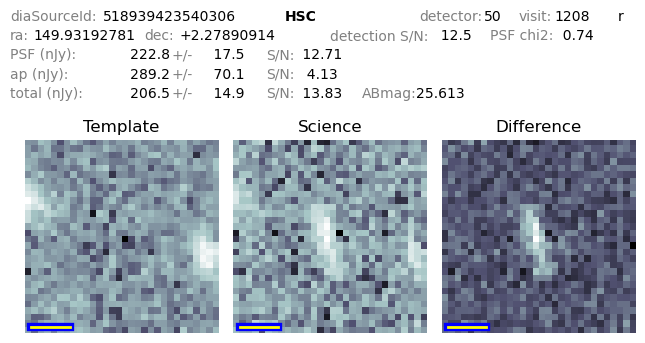

518939423540376


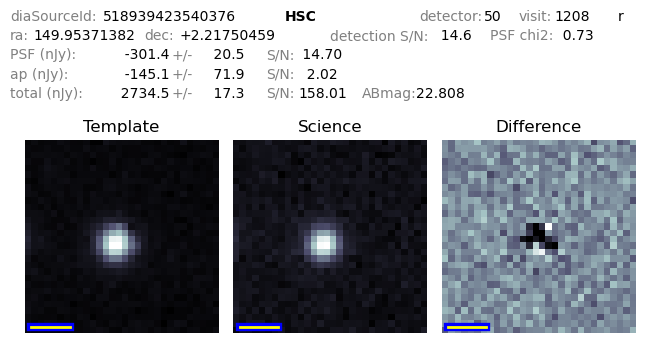

518939423540560


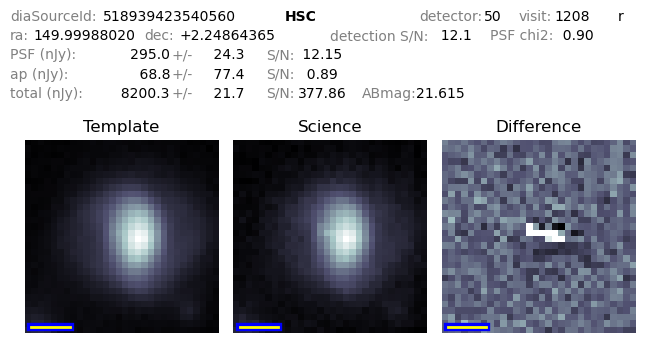

518939423540601


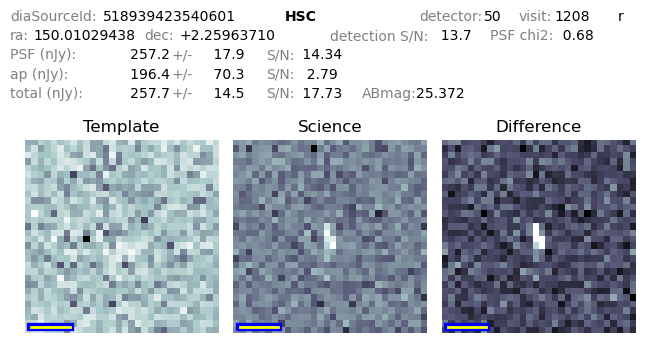

518939423540636


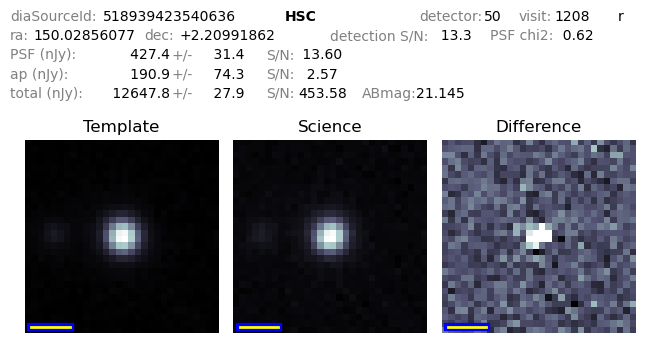

518939423540679


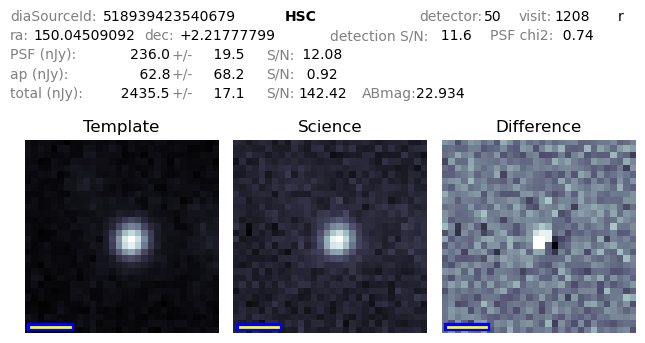

518939423540682


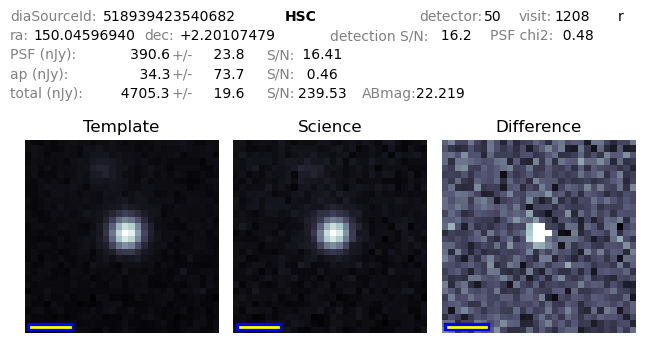

518954455925352


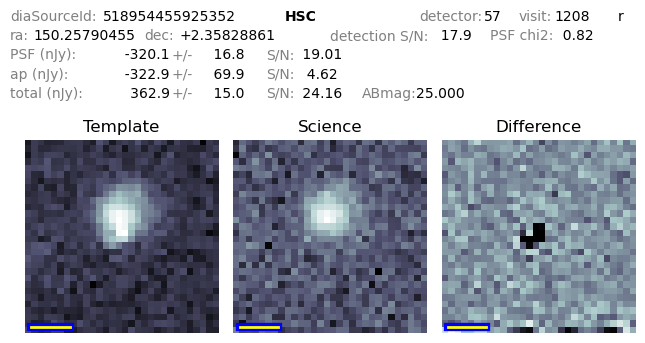

518956603408996


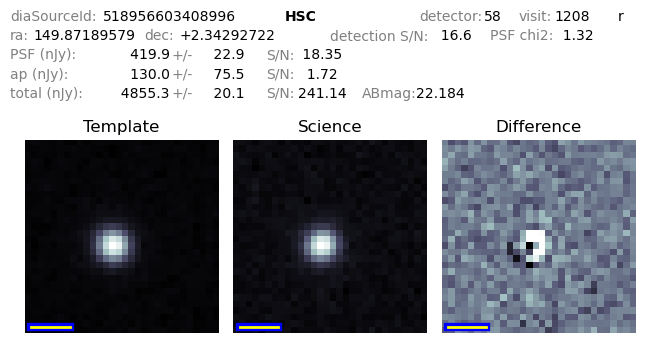

518956603409083


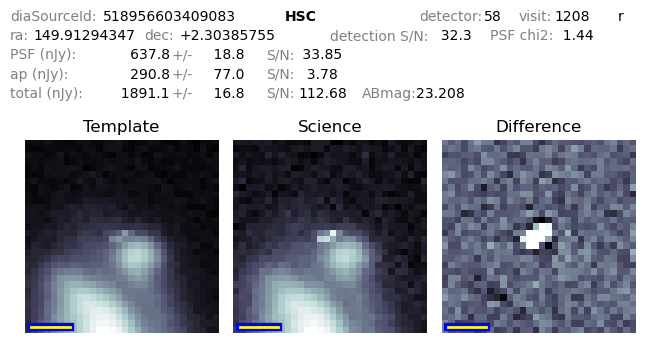

518956603409240


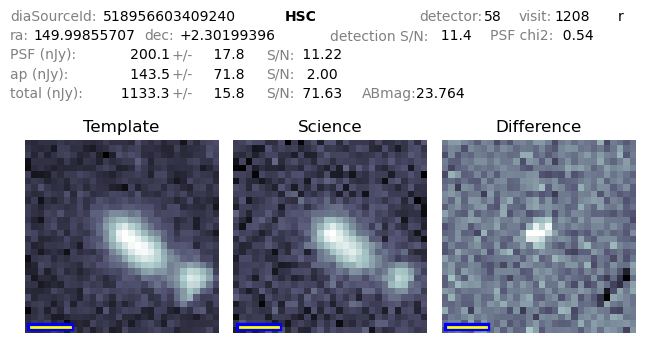

518956603409291


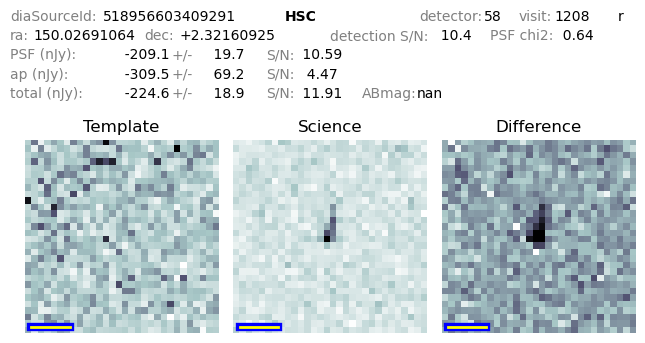

518971635794802


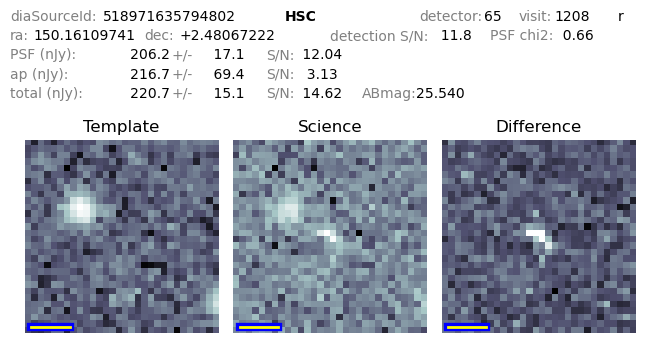

518971635794955


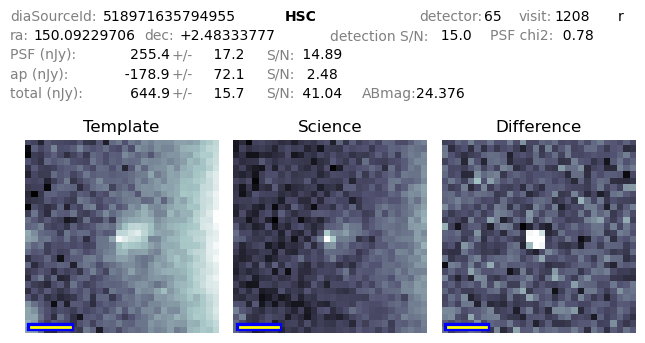

518973783278596


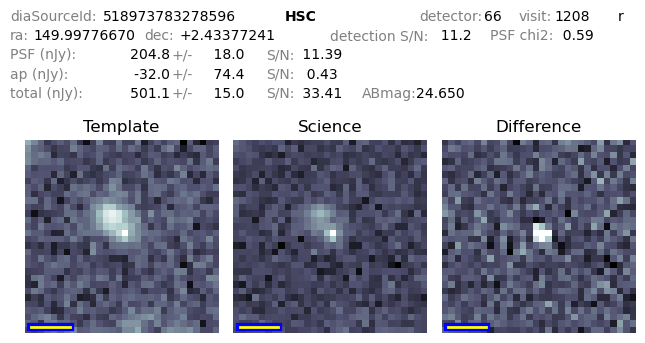

518973783278638


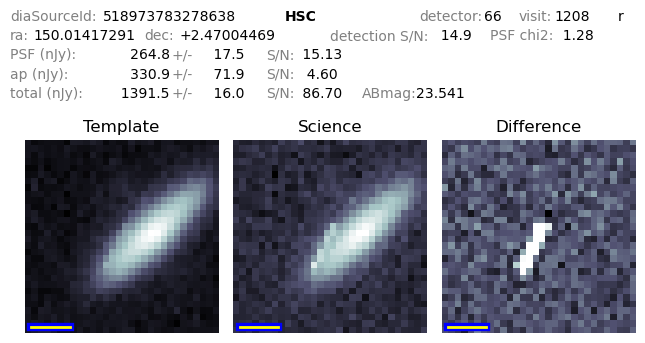

521514256433762


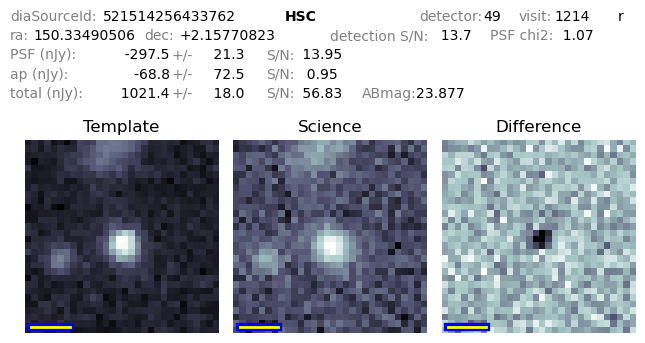

521514256433788


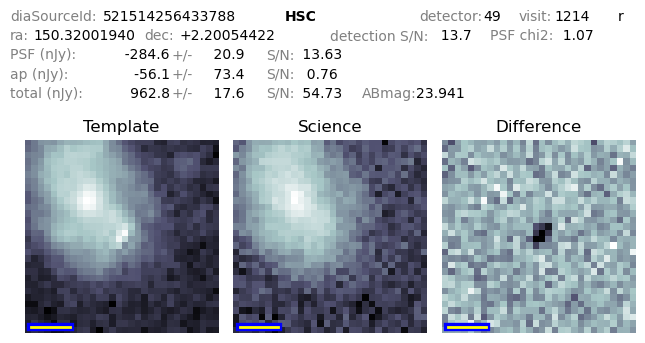

521514256433913


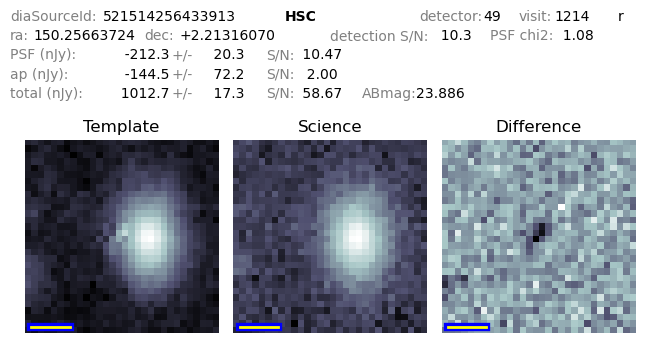

In [42]:
plotSources(autoLow_noFakes_snrHigh_noDipole, path=cauto_noFakes._output_path, offset=0,
            limit=50)

In [43]:
print(apLow_snrHigh_noDipole.loc[apLow_snrHigh_noDipole['diaSourceId']==517219289138136,['ra',
                                                                                         'decl',
                                                           'psFlux',
                                                           'psFluxErr',
                                                           'apFlux',
                                                           'apFluxErr',
                                                           'snr'
                                                          ]])

             ra      decl      psFlux  psFluxErr      apFlux  apFluxErr  \
110  150.159289  2.175013 -236.909238   19.73047 -317.807759  70.447205   

           snr  
110  11.847897  


521514256434032


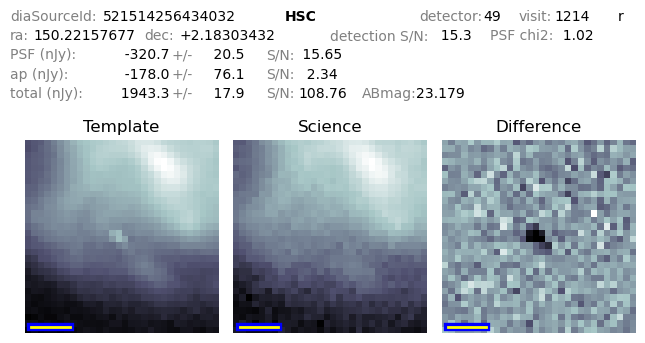

In [44]:
plotSources(autoLow_snrHigh_noDipole.loc[(autoLow_snrHigh_noDipole['ra']>150.22157)
                                         & (autoLow_snrHigh_noDipole['ra']<150.22158)
                                         & (autoLow_snrHigh_noDipole['decl']>2.18303)
                                         & (autoLow_snrHigh_noDipole['decl']<2.18304)],
            path=cauto._output_path, offset=0,limit=3)

## Conclusions

One see very different results if one uses the 'goodSeeingDiff' or the 'fakes_goodSeeingDiff' image type when plotting the cutouts. In the latter case I was not able to find any cases of an obviously missing source in the cutouts. It is likely that the discrepancy seen before is due, at least in large part, to the introduction of fakes and not always pulling the proper product out when looking at the cutouts.